In [4]:

# # Data Loading and Preprocessing for Housing Market Analysis


# Steps to load in Dataset:
# 1. Go to files tab
# 2. Press upload and load in the housing market data file

# from google.colab import drive
# drive.mount('/content/drive') # Uncomment if running in Google Colab and need to mount Google Drive

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

encoder = LabelEncoder()


In [5]:
# ## Data EDA/CLEANUP: Loading, Imputation, and Feature Selection

# Load data using the same file name as the reference code
data = pd.read_csv('city_market_tracker_EDA.tsv', sep='\t')
print(f"Original data shape: {data.shape}")

imp = IterativeImputer(max_iter = 10, random_state = 0)

# Fill missing values based on percentage of NaNs
for col in data.columns:
    nan_percent = data[col].isna().mean() * 100

    if 0 < nan_percent <= 40:
        # Fill with mean for columns with 0-40% missing data
        mean_value = data[col].mean()
        data[col].fillna(mean_value, inplace = True)

    elif 41 <= nan_percent <= 70:
        # Fill using IterativeImputer for columns with 41-70% missing data
        reshaped = data[[col]]
        data[col] = imp.fit_transform(reshaped)

# Select numeric columns and drop columns with only one unique value
numeric_df = data.select_dtypes(include = ['number'])
numeric_df = numeric_df.dropna(axis = 1, how='all')
numeric_df = numeric_df.loc[:, numeric_df.nunique() > 1]

print(f"Numeric data shape after cleaning: {numeric_df.shape}")

Original data shape: (6010471, 58)
Numeric data shape after cleaning: (6010471, 45)


In [6]:
# Remove highly correlated features (absolute correlation > 0.75)
corr_matrix = numeric_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features to drop
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Drop the columns from the numeric dataframe
reduced_df = numeric_df.drop(columns=to_drop)

print(f"Columns dropped due to high correlation: {to_drop}")
print(f"Reduced numeric data shape: {reduced_df.shape}")

Columns dropped due to high correlation: ['MEDIAN_PPSF_MOM', 'MEDIAN_PPSF_YOY', 'MEDIAN_LIST_PPSF_MOM', 'PENDING_SALES', 'NEW_LISTINGS', 'INVENTORY']
Reduced numeric data shape: (6010471, 39)


In [7]:
# Remove Outliers (capping at 1.5*IQR)
for col in reduced_df.columns:
    Q1, Q3 = reduced_df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    reduced_df[col] = reduced_df[col].clip(lower, upper)

# Recombine numeric and non-numeric dataframes
non_numeric_df = data.select_dtypes(exclude=['number'])
final_df = pd.concat([non_numeric_df, reduced_df], axis=1)

print(f"Final data shape after outlier removal and recombination: {final_df.shape}")

Final data shape after outlier removal and recombination: (6010471, 50)


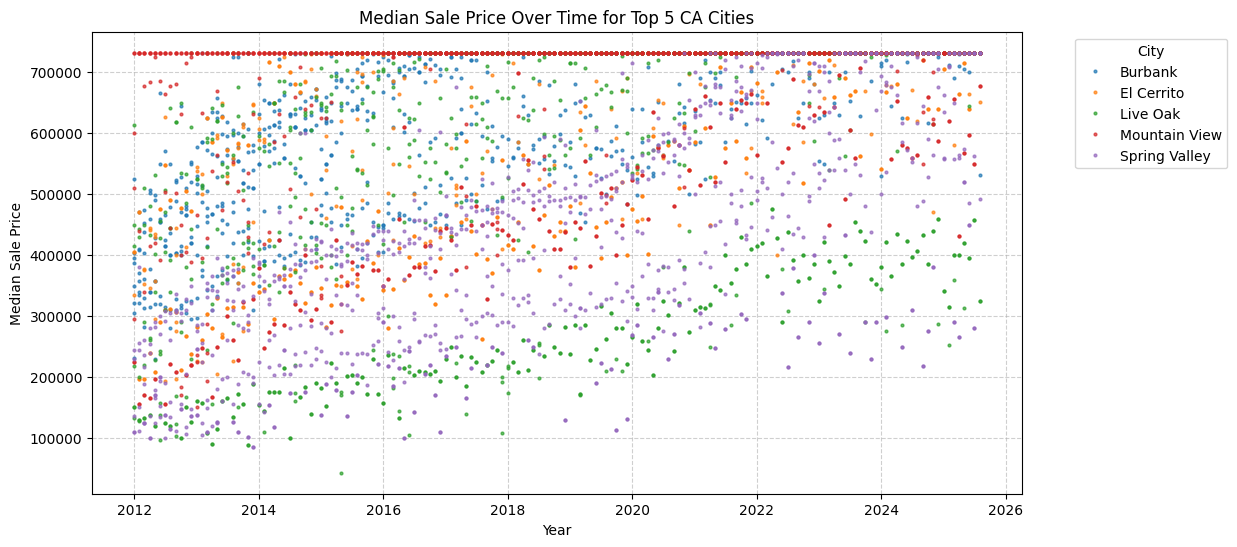

In [8]:
# ## Exploratory Data Analysis (EDA)


# PLOT TOP 5 CITIES IN CALIFORNIA AND THEIR MEDIAN SALE PRICES

# Filter data for California
graph = final_df[final_df['STATE'] == 'California']
top = graph['CITY'].value_counts().head(5).index.to_list()

# Filter for top 5 cities
top_df = graph[graph['CITY'].isin(top)].copy()

# Convert date column for plotting purposes
top_df['DATETIME'] = pd.to_datetime(top_df['PERIOD_BEGIN'])
top_df.loc[:, 'DATETIME_DELTA'] = (top_df['DATETIME'] - top_df['DATETIME'].min()) / np.timedelta64(1,'D') / 365.25 + 2012

# Filter to columns needed for graphing
graph_df = top_df[['DATETIME_DELTA', 'MEDIAN_SALE_PRICE', 'CITY']]
groups = graph_df.groupby('CITY')

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.margins(0.05)
for name, group, in groups:
    ax.plot(group.DATETIME_DELTA, group.MEDIAN_SALE_PRICE, marker='o',
             linestyle = '', ms=2, alpha=0.7, label=name)
ax.set_xlabel('Year')
ax.set_ylabel('Median Sale Price')
ax.set_title('Median Sale Price Over Time for Top 5 CA Cities')
ax.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [11]:
# ## Linear Regression Model


df_lr = final_df[final_df['STATE'] == 'California'].copy()

# Drop unnecessary columns
columns_to_drop = [
    'PERIOD_BEGIN', 'PERIOD_END',
    'STATE', 'STATE_CODE',
    'REGION_TYPE',
]

df_lr = df_lr.drop(columns=columns_to_drop, errors='ignore')

# Define features (X) and target (y)
X = df_lr.drop(columns=['MEDIAN_SALE_PRICE'])
y = df_lr['MEDIAN_SALE_PRICE']

# Handle categorical variables (Label Encoding for high-cardinality, One-Hot for others)
categorical_columns = X.select_dtypes(include=['object']).columns
print("Unique categorical value counts:")
for col in categorical_columns:
    print(f"  {col}: {X[col].nunique()} unique values")

high_cardinality_cols = []
for col in categorical_columns:
    if X[col].nunique() > 50:# Threshold for high cardinality
        high_cardinality_cols.append(col)
        le = LabelEncoder()
        # Apply Label Encoding
        X[col] = le.fit_transform(X[col].astype(str))

# One-hot encode the remaining low-cardinality columns
remaining_cats = [col for col in categorical_columns if col not in high_cardinality_cols]
if len(remaining_cats) > 0:
    X = pd.get_dummies(X, columns=remaining_cats, drop_first=True)

print(f"\nFinal feature count: {X.shape[1]}")

Unique categorical value counts:
  REGION: 1415 unique values
  CITY: 1415 unique values
  PROPERTY_TYPE: 5 unique values
  PARENT_METRO_REGION: 37 unique values
  LAST_UPDATED: 1 unique values

Final feature count: 81


In [12]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# Train Linear Regression model
print("\nTraining Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate performance
lr_r2 = r2_score(y_test, y_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lr_mae = mean_absolute_error(y_test, y_pred)

print(f"\n{'='*50}")
print("LINEAR REGRESSION PERFORMANCE")
print(f"{'='*50}")
print(f"R² Score: {lr_r2:.4f}")
print(f"RMSE: ${lr_rmse:,.2f}")
print(f"MAE: ${lr_mae:,.2f}")

Training samples: 381178, Test samples: 95295

Training Linear Regression model...

LINEAR REGRESSION PERFORMANCE
R² Score: 0.8533
RMSE: $82,745.38
MAE: $60,267.69
